# 0. Import

## 0.1 Import libraries

In [15]:
import pandas as pd
import numpy as np      
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns 


In [16]:
# import csv from clean transcripts/AMAZON_full_output.csv
import pandas as pd
df = pd.read_csv('APPLE_finbert_deepseek_output_clean.csv')
df.head()

,quarter,speaker,title,content,sentiment,confidence,sentiment_category,LLM_sentiment,LLM_pct_strong_positive,LLM_pct_slightly_positive,LLM_pct_neutral,LLM_pct_slightly_negative,LLM_pct_strong_negative,Manual Annotations
0,Q1_2025,Suhasini Chandramouli,"Director, Investor Relations","Good afternoon, and welcome to the Apple Q1 fi...",neutral,0.942037,Neutral,Neutral,0.1,0.2,0.6,0.1,0.0,Neutral
1,Q1_2025,Timothy Donald Cook,Chief Executive Officer,"Thank you, Suhasini. Good afternoon, everyone,...",neutral,0.868479,Neutral,Slightly Positive,0.2,0.4,0.3,0.1,0.0,Strong Positive
2,Q1_2025,Kevan Parekh,"Senior Vice President, Chief Financial Officer","Thanks, Tim, and good afternoon, everyone. I'm...",positive,0.942901,Strong Positive,Slightly Positive,0.2,0.4,0.3,0.1,0.0,Slightly Positive
3,Q1_2025,Suhasini Chandramouli,"Director, Investor Relations","Thank you, Kevan. We ask that you limit yourse...",neutral,0.937472,Neutral,Neutral,0.1,0.2,0.6,0.1,0.0,Neutral
4,Q1_2025,Erik Woodring,Analyst,"Great, guys. Thanks so much for taking my ques...",neutral,0.825077,Neutral,Neutral,0.1,0.2,0.6,0.1,0.0,Neutral


# 1.0 FinBERT vs LLM vs Manual Annotation

In [17]:
# --- Setup ---
# pip install scikit-learn seaborn  # (run this in a cell if you don't already have them)
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns  # optional, just for a nicely formatted table

# === CONFIG: set your actual column names here ===
Y_TRUE_COL = "Manual Annotations"     # e.g. 'ground_truth' or 'human_label'
Y_PRED_COL = "sentiment_category"     # e.g. 'model_label'
QUARTER_COL = "quarter"       # e.g. 'fiscal_quarter'
# ================================================

# If your classes are exactly these strings, keep them as is.
# This order will be used for the confusion matrix axes and reports.
CLASS_ORDER = [
    "Strong Positive",
    "Slightly Positive",
    "Neutral",
    "Slightly Negative",
    "Strong Negative"
]

# ----- Helper: safe classification metrics for a subset -----
def compute_basic_metrics(y_true, y_pred, labels):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
    }

# ================== MAIN ANALYSIS ==================
# 1) Keep only rows where we have both labels and a quarter
work = df[[Y_TRUE_COL, Y_PRED_COL, QUARTER_COL]].dropna().copy()

# 2) Enforce consistent ordered categories (helps with clean confusion matrices)
for c in [Y_TRUE_COL, Y_PRED_COL]:
    work[c] = pd.Categorical(work[c], categories=CLASS_ORDER, ordered=True)

# 3) Row-level eval frame you can reuse for plotting/stats later
work["is_correct"] = (work[Y_TRUE_COL] == work[Y_PRED_COL])

# 4) Overall metrics
overall_metrics = compute_basic_metrics(work[Y_TRUE_COL], work[Y_PRED_COL], CLASS_ORDER)
overall_report = classification_report(
    work[Y_TRUE_COL],
    work[Y_PRED_COL],
    labels=CLASS_ORDER,
    target_names=CLASS_ORDER,
    output_dict=True,
    zero_division=0
)
overall_report_df = pd.DataFrame(overall_report).T  # nice table

print("=== Overall metrics ===")
for k, v in overall_metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== Per-class precision/recall/F1 ===")
display(overall_report_df)

# 5) Confusion matrices (counts and normalized)
cm_counts = confusion_matrix(
    work[Y_TRUE_COL], work[Y_PRED_COL],
    labels=CLASS_ORDER
)
cm_normalized = confusion_matrix(
    work[Y_TRUE_COL], work[Y_PRED_COL],
    labels=CLASS_ORDER,
    normalize="true"  # each row sums to 1
)

=== Overall metrics ===
accuracy: 0.7430
f1_macro: 0.4162
f1_weighted: 0.7442
precision_macro: 0.4344
recall_macro: 0.4013

=== Per-class precision/recall/F1 ===


,precision,recall,f1-score,support
Strong Positive,0.464286,0.371429,0.412698,35.000000
Slightly Positive,0.395833,0.380000,0.387755,50.000000
Neutral,0.857143,0.870662,0.863850,317.000000
Slightly Negative,0.454545,0.384615,0.416667,26.000000
Strong Negative,0.000000,0.000000,0.000000,0.000000
accuracy,0.742991,0.742991,0.742991,0.742991
macro avg,0.434361,0.401341,0.416194,428.000000
weighted avg,0.746669,0.742991,0.744173,428.000000



=== Overall metrics for FinBERT ===
accuracy: 0.7430
f1_macro: 0.4162
f1_weighted: 0.7442
precision_macro: 0.4344
recall_macro: 0.4013

=== Per-class precision/recall/F1 for FinBERT ===


,precision,recall,f1-score,support
Strong Positive,0.464286,0.371429,0.412698,35.000000
Slightly Positive,0.395833,0.380000,0.387755,50.000000
Neutral,0.857143,0.870662,0.863850,317.000000
Slightly Negative,0.454545,0.384615,0.416667,26.000000
Strong Negative,0.000000,0.000000,0.000000,0.000000
accuracy,0.742991,0.742991,0.742991,0.742991
macro avg,0.434361,0.401341,0.416194,428.000000
weighted avg,0.746669,0.742991,0.744173,428.000000


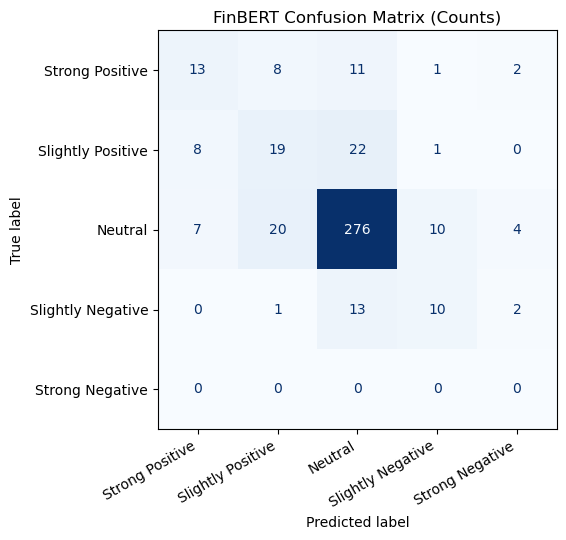

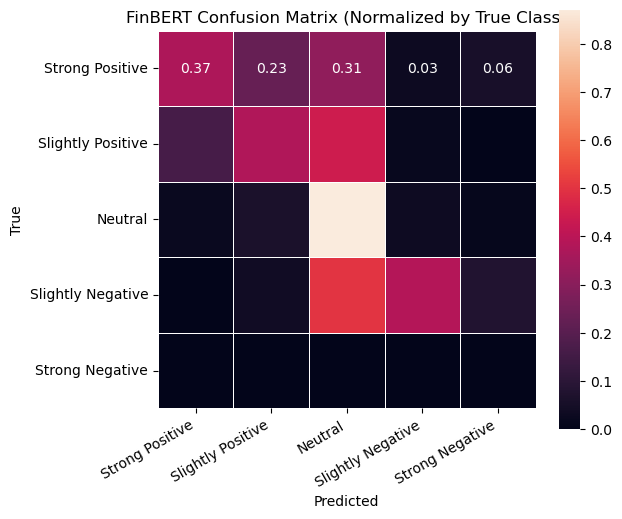


=== Per-quarter summary for FinBERT ===


,quarter,accuracy,f1_macro,f1_weighted,precision_macro,recall_macro,n,accuracy_pct,correct_pct
0,Q1_2022,0.903846,0.838010,0.904127,0.816667,0.864499,52.0,90.384615,90.384615
1,Q1_2023,0.500000,0.166387,0.450711,0.161538,0.179472,52.0,50.000000,50.000000
2,Q1_2025,0.639344,0.251396,0.637823,0.259091,0.245908,61.0,63.934426,63.934426
3,Q2_2022,0.767857,0.333333,0.783730,0.355152,0.440580,56.0,76.785714,76.785714
4,Q3_2022,0.826087,0.699548,0.823765,0.684896,0.740530,46.0,82.608696,82.608696
5,Q4_2021,0.949153,0.873527,0.955258,0.812500,0.985577,59.0,94.915254,94.915254
6,Q4_2022,0.622222,0.280952,0.631922,0.329583,0.256528,45.0,62.222222,62.222222
7,Q4_2024,0.719298,0.342662,0.692934,0.450000,0.357857,57.0,71.929825,71.929825



=== Overall metrics for LLM ===
accuracy: 0.6799
f1_macro: 0.3915
f1_weighted: 0.6812
precision_macro: 0.4073
recall_macro: 0.4278

=== Per-class precision/recall/F1 for LLM ===


,precision,recall,f1-score,support
Strong Positive,0.500000,0.285714,0.363636,35.0
Slightly Positive,0.273504,0.640000,0.383234,50.0
Neutral,0.855670,0.785489,0.819079,317.0
Slightly Negative,0.000000,0.000000,0.000000,26.0
Strong Negative,0.000000,0.000000,0.000000,0.0
micro avg,0.679907,0.679907,0.679907,428.0
macro avg,0.325835,0.342241,0.313190,428.0
weighted avg,0.706595,0.679907,0.681161,428.0


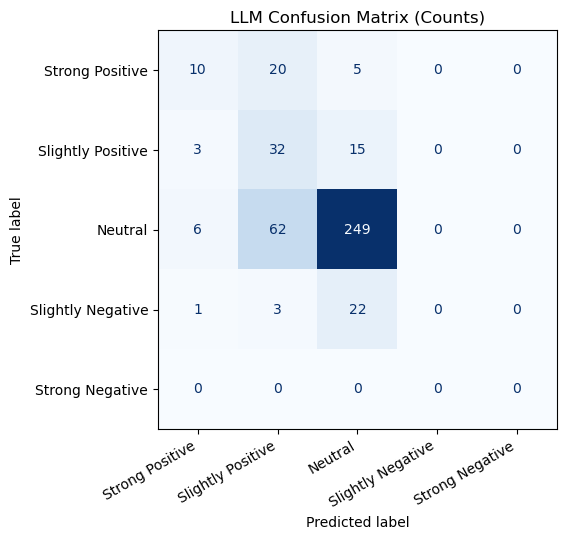

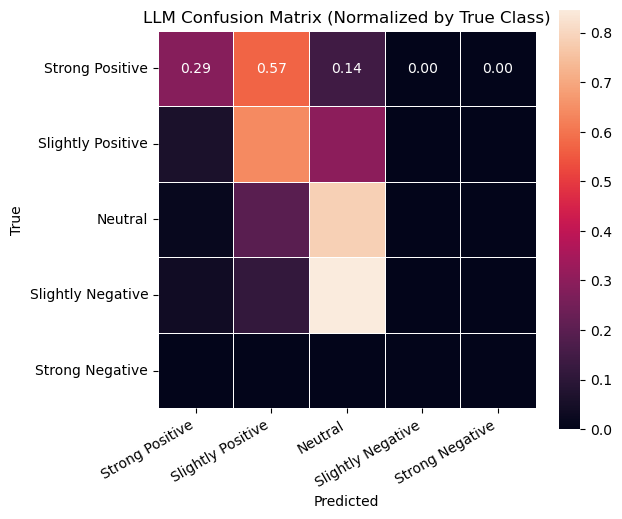


=== Per-quarter summary for LLM ===


,quarter,accuracy,f1_macro,f1_weighted,precision_macro,recall_macro,n,accuracy_pct,correct_pct
0,Q1_2022,0.576923,0.456915,0.649728,0.488536,0.503252,52.0,57.692308,57.692308
1,Q1_2023,0.653846,0.379545,0.616608,0.370742,0.395772,52.0,65.384615,65.384615
2,Q1_2025,0.770492,0.495136,0.742489,0.458943,0.567301,61.0,77.049180,77.049180
3,Q2_2022,0.714286,0.251344,0.697869,0.235225,0.295290,56.0,71.428571,71.428571
4,Q3_2022,0.673913,0.418808,0.627685,0.381944,0.503788,46.0,67.391304,67.391304
5,Q4_2021,0.559322,0.422840,0.646621,0.435824,0.634615,59.0,55.932203,55.932203
6,Q4_2022,0.711111,0.435107,0.701069,0.469792,0.435868,45.0,71.111111,71.111111
7,Q4_2024,0.771930,0.441103,0.728796,0.570076,0.466071,57.0,77.192982,77.192982


In [18]:
# --- Setup ---
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# --- Function to evaluate one model ---
def evaluate_sentiment_model(df, y_true_col, y_pred_col, model_name, class_order, quarter_col):
    # Filter and clean
    work = df[[y_true_col, y_pred_col, quarter_col]].dropna().copy()

    # Set category order for consistency
    for c in [y_true_col, y_pred_col]:
        work[c] = pd.Categorical(work[c], categories=class_order, ordered=True)

    work["is_correct"] = (work[y_true_col] == work[y_pred_col])

    # --- Metrics function ---
    def compute_basic_metrics(y_true, y_pred, labels):
        return {
            "accuracy": accuracy_score(y_true, y_pred),
            "f1_macro": f1_score(y_true, y_pred, average="macro"),
            "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
            "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
            "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        }

    # --- Overall metrics ---
    overall_metrics = compute_basic_metrics(work[y_true_col], work[y_pred_col], class_order)
    overall_report = classification_report(
        work[y_true_col],
        work[y_pred_col],
        labels=class_order,
        target_names=class_order,
        output_dict=True,
        zero_division=0
    )
    overall_report_df = pd.DataFrame(overall_report).T

    print(f"\n=== Overall metrics for {model_name} ===")
    for k, v in overall_metrics.items():
        print(f"{k}: {v:.4f}")

    print(f"\n=== Per-class precision/recall/F1 for {model_name} ===")
    display(overall_report_df)

    # --- Confusion Matrices ---
    cm_counts = confusion_matrix(work[y_true_col], work[y_pred_col], labels=class_order)
    cm_normalized = confusion_matrix(work[y_true_col], work[y_pred_col], labels=class_order, normalize="true")

    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_counts, display_labels=class_order)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"{model_name} Confusion Matrix (Counts)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    sns.heatmap(pd.DataFrame(cm_normalized, index=class_order, columns=class_order),
                annot=True, fmt=".2f", linewidths=.5, square=True, cbar=True)
    ax.set_title(f"{model_name} Confusion Matrix (Normalized by True Class)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.xticks(rotation=30, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --- Per-quarter metrics ---
    def quarter_metrics(g):
        m = compute_basic_metrics(g[y_true_col], g[y_pred_col], class_order)
        m["n"] = len(g)
        m["accuracy_pct"] = 100 * m["accuracy"]
        m["correct_pct"] = 100 * g["is_correct"].mean()
        return pd.Series(m)

    quarter_summary = (
        work
        .groupby(quarter_col, dropna=False)
        .apply(quarter_metrics)
        .reset_index()
        .sort_values(quarter_col)
    )

    print(f"\n=== Per-quarter summary for {model_name} ===")
    display(quarter_summary)

# --- Configuration (common variables) ---
CLASS_ORDER = ["Strong Positive", "Slightly Positive", "Neutral", "Slightly Negative", "Strong Negative"]
QUARTER_COL = "quarter"
Y_TRUE_COL = "Manual Annotations"

# --- Run the comparison ---
evaluate_sentiment_model(df, Y_TRUE_COL, "sentiment_category", "FinBERT", CLASS_ORDER, QUARTER_COL)
evaluate_sentiment_model(df, Y_TRUE_COL, "LLM_sentiment", "LLM", CLASS_ORDER, QUARTER_COL)


# 2.0 Comparison of Sentiment Analysis against stock price movements

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.graph_objects as go

# PARAMETERS
TICKER = "AAPL"

# Download earnings calendar
stock = yf.Ticker(TICKER)
earnings = stock.get_earnings_dates(limit=20)
earnings.index = pd.to_datetime(earnings.index).tz_localize(None)
earnings["Earnings Date"] = earnings.index.date
earnings_dates = [d for d in earnings["Earnings Date"].tolist() if d <= datetime.today().date()]

# Sentiment classifier
def categorize_sentiment(change):
    if change > 5:
        return "Strong Positive"
    elif change > 1:
        return "Slightly Positive"
    elif change >= -1:
        return "Neutral"
    elif change >= -5:
        return "Slightly Negative"
    else:
        return "Strong Negative"

# Collect results around earnings dates
results = []

for ed in earnings_dates:
    ed = pd.to_datetime(ed)
    start_date = ed - pd.Timedelta(days=5)
    end_date = ed + pd.Timedelta(days=5)
    
    data = yf.Ticker(TICKER).history(start=start_date, end=end_date)[['Close']].copy()
    data.index = data.index.tz_localize(None)
    trading_days = data.index

    try:
        t_minus_2 = trading_days[trading_days < ed][-2]
        t_plus_2 = trading_days[trading_days > ed][1]
    except IndexError:
        continue

    price_t_minus_2 = data.loc[t_minus_2, 'Close']
    price_t_plus_2 = data.loc[t_plus_2, 'Close']
    pct_change = ((price_t_plus_2 - price_t_minus_2) / price_t_minus_2) * 100
    sentiment = categorize_sentiment(pct_change)
    
    eps_row = earnings.loc[earnings["Earnings Date"] == ed.date()].iloc[0]

    results.append({
        "Earnings Date": ed.date(),
        "T-2 Date": t_minus_2.date(),
        "T+2 Date": t_plus_2.date(),
        "T-2 Price": round(price_t_minus_2, 2),
        "T+2 Price": round(price_t_plus_2, 2),
        "% Change": round(pct_change, 2),
        "Sentiment": sentiment,
        "EPS Estimate": eps_row["EPS Estimate"],
        "Reported EPS": eps_row["Reported EPS"],
        "Surprise(%)": eps_row["Surprise(%)"]
    })

df_results = pd.DataFrame(results)

# Download full price history
earliest_date = pd.to_datetime(min(df_results["Earnings Date"])) - pd.Timedelta(days=30)
df_full = yf.Ticker(TICKER).history(start=earliest_date)[['Close']].copy()
df_full.index = df_full.index.tz_localize(None)
df_full['Date'] = df_full.index

# Sentiment color mapping
sentiment_colors = {
    "Strong Positive": "green",
    "Slightly Positive": "lime",
    "Neutral": "gray",
    "Slightly Negative": "orange",
    "Strong Negative": "red"
}

# Plotly figure
fig = go.Figure()

# Add stock price line
fig.add_trace(go.Scatter(
    x=df_full['Date'], y=df_full['Close'],
    mode='lines', name=f'{TICKER} Price',
    line=dict(color='black')
))

# Add sentiment scatter markers
for _, row in df_results.iterrows():
    earnings_date = pd.to_datetime(row["Earnings Date"])
    price = df_full.loc[df_full['Date'] == earnings_date, 'Close']
    if price.empty:
        closest_idx = (df_full['Date'] - earnings_date).abs().idxmin()
        price = df_full.loc[closest_idx, 'Close']
        earnings_date = df_full.loc[closest_idx, 'Date']
    else:
        price = price.values[0]

    fig.add_trace(go.Scatter(
        x=[earnings_date], y=[price],
        mode='markers+text',
        marker=dict(
            color=sentiment_colors[row["Sentiment"]],
            size=12,
            line=dict(color='black', width=1)
        ),
        name=row["Sentiment"],
        hovertemplate=(
            f"<b>{earnings_date.date()}</b><br>"
            f"Surprise: {row['Surprise(%)']}%<br>"
            f"Change: {row['% Change']}%<br>"
            f"Reported EPS: {row['Reported EPS']}<br>"
            f"Estimate EPS: {row['EPS Estimate']}"
        ),
        showlegend=False
    ))

# Customize layout
fig.update_layout(
    title=f"{TICKER} Earnings Sentiment — EPS Surprise & Stock Reaction",
    xaxis_title="Date",
    yaxis_title="Close Price (USD)",
    template="plotly_white",
    legend_title="Sentiment",
    hovermode="closest"
)

# Manual sentiment legend
for sentiment, color in sentiment_colors.items():
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=10, color=color),
        legendgroup=sentiment,
        showlegend=True,
        name=sentiment
    ))

fig.show()


c:\Users\sadee\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [20]:
# Convert date to pandas datetime
df_results["Earnings Date"] = pd.to_datetime(df_results["Earnings Date"])

# Shift earnings date back by one quarter before formatting
df_results["quarter"] = (
    pd.to_datetime(df_results["Earnings Date"])
    .dt.to_period("Q")         # e.g. 2024Q3                    # shift back one quarter → 2024Q2
).astype(str).str.replace(r"(\d{4})Q([1-4])", r"Q\2_\1", regex=True)




In [21]:
# Step 1: Define mapping
sentiment_to_score = {
    "Strong Negative": -2,
    "Slightly Negative": -1,
    "Neutral": 0,
    "Slightly Positive": 1,
    "Strong Positive": 2
}

# Step 2: Apply mapping to new numeric score columns
df["Manual Annotation_score"] = df["Manual Annotations"].map(sentiment_to_score)
df["sentiment_category_score"] = df["sentiment_category"].map(sentiment_to_score)
df["LLM_sentiment_score"] = df["LLM_sentiment"].map(sentiment_to_score)



In [22]:
# Step 3: Average sentiment scores by quarter
avg_sentiments = (
    df.groupby("quarter")[
        ["Manual Annotation_score", "sentiment_category_score", "LLM_sentiment_score"]
    ]
    .mean()
    .reset_index()
    .rename(columns={
        "Manual Annotation_score": "Manual Sentiment Score",
        "sentiment_category_score": "FinBERT Sentiment Score",
        "LLM_sentiment_score": "LLM Sentiment Score"
    })
)


In [23]:
# Ensure 'quarter' exists in df_results
df_results["quarter"] = pd.to_datetime(df_results["Earnings Date"]).dt.to_period("Q").astype(str).str.replace("Q", "Q")

# Shift earnings date back by one quarter before formatting
df_results["quarter"] = (
    pd.to_datetime(df_results["Earnings Date"])
    .dt.to_period("Q")         # e.g. 2024Q3                  # shift back one quarter → 2024Q2
).astype(str).str.replace(r"(\d{4})Q([1-4])", r"Q\2_\1", regex=True)

# Merge the two DataFrames
merged_df = pd.merge(df_results, avg_sentiments, on="quarter", how="left")


In [24]:
avg_sentiments.head()

,quarter,Manual Sentiment Score,FinBERT Sentiment Score,LLM Sentiment Score
0,Q1_2022,0.326923,0.346154,0.615385
1,Q1_2023,0.365385,0.134615,0.403846
2,Q1_2025,0.409836,0.278689,0.327869
3,Q2_2022,-0.017857,0.142857,0.160714
4,Q3_2022,-0.021739,-0.021739,0.260870


In [25]:
valid_data = merged_df.dropna(subset=["Manual Sentiment Score", "FinBERT Sentiment Score", "LLM Sentiment Score"])

valid_data = valid_data.copy()

# Extract year and quarter as integers
valid_data["year"] = valid_data["quarter"].str.extract(r'_(\d{4})').astype(int)
valid_data["qtr"] = valid_data["quarter"].str.extract(r'Q(\d)_').astype(int)

# Sort by year (desc), then quarter (desc)
valid_data = valid_data.sort_values(by=["year", "qtr"], ascending=[False, False])

# Drop helper columns if not needed
valid_data = valid_data.drop(columns=["year", "qtr"])

valid_data

,Earnings Date,T-2 Date,T+2 Date,T-2 Price,T+2 Price,% Change,Sentiment,EPS Estimate,Reported EPS,Surprise(%),quarter,Manual Sentiment Score,FinBERT Sentiment Score,LLM Sentiment Score
1,2025-01-30,2025-01-28,2025-02-03,237.42,227.20,-4.30,Slightly Negative,2.35,2.40,2.15,Q1_2025,0.409836,0.278689,0.327869
2,2024-10-31,2024-10-29,2024-11-04,232.59,220.98,-4.99,Slightly Negative,1.60,1.64,2.35,Q4_2024,0.210526,0.175439,0.245614
9,2023-02-02,2023-01-31,2023-02-06,142.28,149.62,5.16,Strong Positive,1.94,1.88,-2.88,Q1_2023,0.365385,0.134615,0.403846
10,2022-10-27,2022-10-25,2022-10-31,149.97,150.96,0.66,Neutral,1.27,1.29,1.55,Q4_2022,0.400000,0.066667,0.355556
11,2022-07-28,2022-07-26,2022-08-01,149.04,158.78,6.54,Strong Positive,1.16,1.20,3.25,Q3_2022,-0.021739,-0.021739,0.260870
12,2022-04-28,2022-04-26,2022-05-02,153.92,155.06,0.74,Neutral,1.43,1.52,6.44,Q2_2022,-0.017857,0.142857,0.160714
13,2022-01-27,2022-01-25,2022-01-31,156.65,171.35,9.39,Strong Positive,1.89,2.10,11.17,Q1_2022,0.326923,0.346154,0.615385
14,2021-10-28,2021-10-26,2021-11-01,146.18,145.83,-0.24,Neutral,1.24,1.24,0.30,Q4_2021,0.084746,0.067797,0.559322


## 2.1 LLM vs FinBERT vs Manual Annotation versus Stock Price Movements

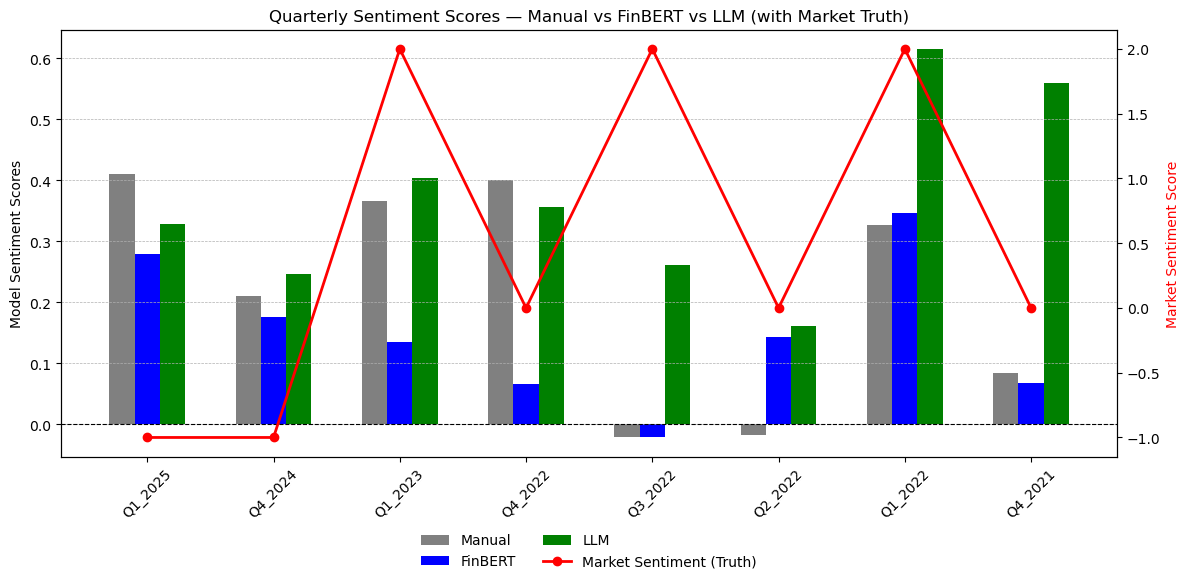

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Step 1: Convert sentiment labels to numeric scores
sentiment_to_score = {
    "Strong Negative": -2,
    "Slightly Negative": -1,
    "Neutral": 0,
    "Slightly Positive": 1,
    "Strong Positive": 2
}

# Apply to your merged DataFrame
merged_df["Market Sentiment Score"] = merged_df["Sentiment"].map(sentiment_to_score)

# Filter to rows that have all sentiment scores and Surprise(%)
valid_data = merged_df.dropna(subset=[
    "Manual Sentiment Score", 
    "FinBERT Sentiment Score", 
    "LLM Sentiment Score", 
    "Market Sentiment Score", 
    "Surprise(%)"
])

# Step 2: Bar chart with secondary y-axis for market sentiment
bar_width = 0.2
quarters = valid_data["quarter"]
index = np.arange(len(quarters))

fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary Y-axis: Sentiment Bars
ax1.bar(index - bar_width, valid_data["Manual Sentiment Score"], bar_width, label="Manual", color="gray")
ax1.bar(index, valid_data["FinBERT Sentiment Score"], bar_width, label="FinBERT", color="blue")
ax1.bar(index + bar_width, valid_data["LLM Sentiment Score"], bar_width, label="LLM", color="green")
ax1.set_ylabel("Model Sentiment Scores")
ax1.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax1.set_xticks(index)
ax1.set_xticklabels(quarters, rotation=45)
ax1.grid(axis="y", linestyle="--", linewidth=0.5)

# Secondary Y-axis: Market Sentiment
ax2 = ax1.twinx()
ax2.plot(index, valid_data["Market Sentiment Score"], marker='o', linestyle='-', color='red', linewidth=2, label="Market Sentiment (Truth)")
ax2.set_ylabel("Market Sentiment Score")
ax2.yaxis.label.set_color("red")  # Make the y-axis label red

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines_1 + lines_2, 
    labels_1 + labels_2,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),  # center-bottom, outside the plot
    ncol=2,                       # display items in two columns (adjust as needed)
    frameon=False
)


plt.title("Quarterly Sentiment Scores — Manual vs FinBERT vs LLM (with Market Truth)")
plt.tight_layout()
plt.show()



# 2.2 LLM vs FinBERT vs Manual Annotation Linear Regressions

### 2.2.1 Market Sentiment Score

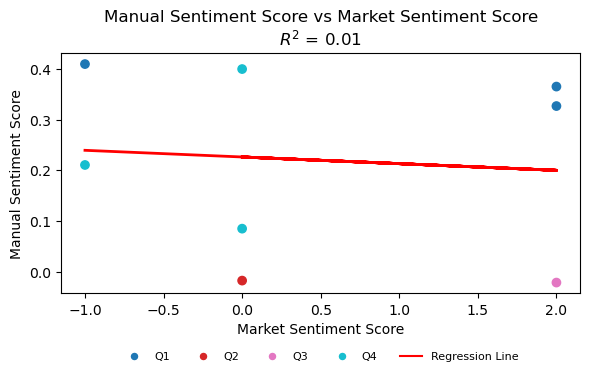

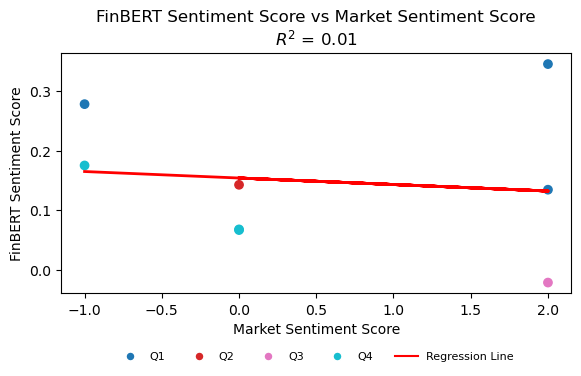

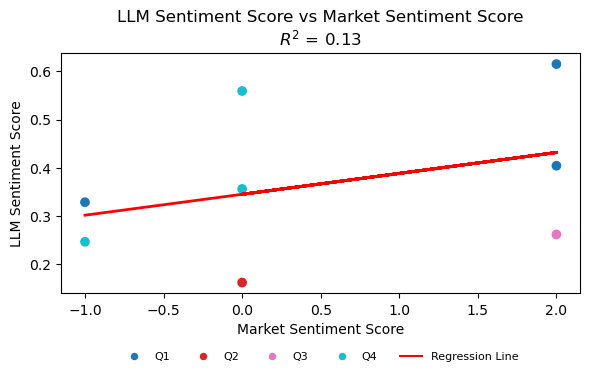

In [27]:
# X-axis: Market Sentiment Score
X = valid_data[["Market Sentiment Score"]].values

# Extract just the quarter (Q1, Q2, Q3, Q4) regardless of year
quarters = valid_data["quarter"].str.split("_").str[0].astype("category")
quarter_codes = quarters.cat.codes
colors = cm.tab10(quarter_codes / quarter_codes.max())  # normalize to [0,1]

# Loop through each sentiment type
for col in ["Manual Sentiment Score", "FinBERT Sentiment Score", "LLM Sentiment Score"]:
    y = valid_data[col].values

    # Fit linear regression
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(X, y, c=colors, label=None)  # color by quarter only
    plt.plot(X, y_pred, color="red", linewidth=2, label="Regression Line")
    plt.xlabel("Market Sentiment Score")
    plt.ylabel(col)
    plt.title(f"{col} vs Market Sentiment Score\n$R^2$ = {r2:.2f}")

    # Add legend for quarters (Q1–Q4)
    handles = [plt.Line2D([0], [0], marker="o", color="w", label=q, 
                          markerfacecolor=cm.tab10(i / quarter_codes.max()), markersize=8)
               for i, q in enumerate(quarters.cat.categories)]
    legend = plt.legend(
    handles=handles + [plt.Line2D([], [], color="red", label="Regression Line")],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=5,                # all items in one row
    frameon=False,
    fontsize=8,            # smaller font
    title_fontsize=9,      # smaller title font
    markerscale=0.8        # shrink marker size
)

    plt.tight_layout()
    plt.show()


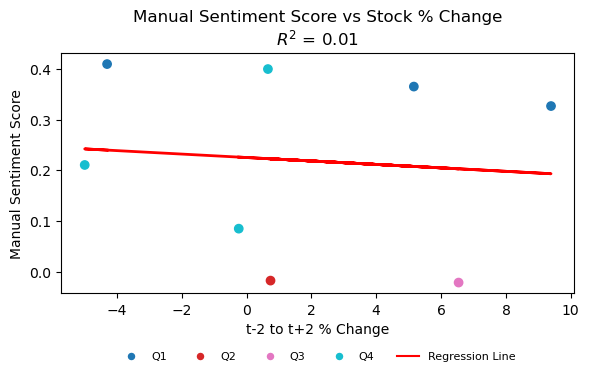

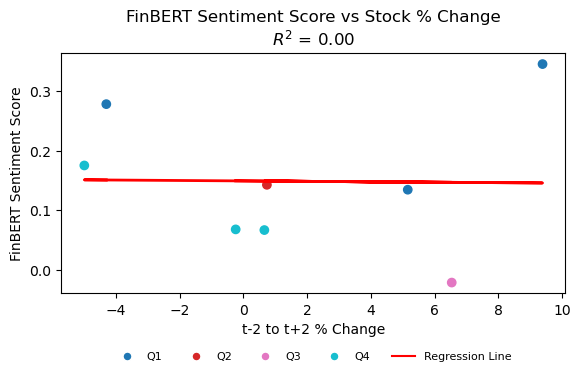

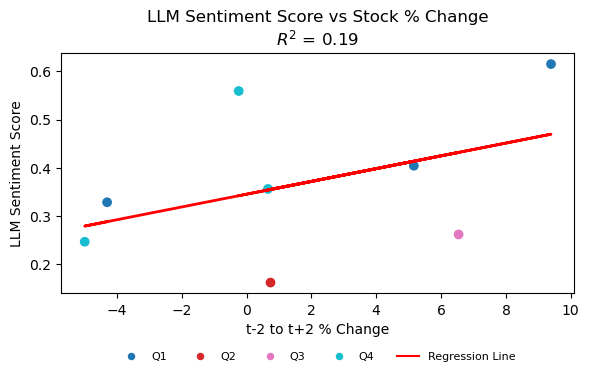

In [28]:

# X-axis: Market Sentiment Score
X = valid_data[["% Change"]].values

# Extract just the quarter (Q1, Q2, Q3, Q4) regardless of year
quarters = valid_data["quarter"].str.split("_").str[0].astype("category")
quarter_codes = quarters.cat.codes
colors = cm.tab10(quarter_codes / quarter_codes.max())  # normalize to [0,1]

# Loop through each sentiment type
for col in ["Manual Sentiment Score", "FinBERT Sentiment Score", "LLM Sentiment Score"]:
    y = valid_data[col].values

    # Fit linear regression
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(X, y, c=colors, label=None)  # color by quarter only
    plt.plot(X, y_pred, color="red", linewidth=2, label="Regression Line")
    plt.xlabel("t-2 to t+2 % Change")
    plt.ylabel(col)
    plt.title(f"{col} vs Stock % Change\n$R^2$ = {r2:.2f}")

    # Add legend for quarters (Q1–Q4)
    handles = [plt.Line2D([0], [0], marker="o", color="w", label=q, 
                          markerfacecolor=cm.tab10(i / quarter_codes.max()), markersize=8)
               for i, q in enumerate(quarters.cat.categories)]
    legend = plt.legend(
    handles=handles + [plt.Line2D([], [], color="red", label="Regression Line")],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=5,                # all items in one row
    frameon=False,
    fontsize=8,            # smaller font
    title_fontsize=9,      # smaller title font
    markerscale=0.8        # shrink marker size
)

    plt.tight_layout()
    plt.show()
